In [1]:
import mbuild
import foyer
import mosdef_cassandra as mc
import unyt as u

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

from mosdef_cassandra.analysis import ThermoProps
from mosdef_cassandra.utils.tempdir import temporary_cd

# Filter some warnings -- to cleanup output for this demo
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)
from parmed.exceptions import OpenMMWarning
filterwarnings('ignore', category=OpenMMWarning)

%matplotlib inline


In [2]:
rootdir = "/home/woodrowwilson/Documents/Projects/MSELProjects/"

adsorbate = mbuild.load(rootdir + 'Resources/pdb/TraPPE/carbon-dioxide_trappe.pdb')
ff_ads = foyer.Forcefield(rootdir + 'Resources/foyer/TraPPE_small_5_carbon_dioxide.xml')
adsorbate_typed = ff_ads.apply(adsorbate)


In [3]:
adsorbate.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
temperature = 250.0 * u.K

custom_args = {
    "charge_style" : "ewald",
    "vdw_cutoff" : 14.0 * u.angstrom,
    "prop_freq" : 10,
}


mus_adsorbate = np.arange(-35, -27, 1) * u.kJ/u.mol

for mu_adsorbate in mus_adsorbate:
    dirname = f'pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    with temporary_cd(dirname):
        
        species_list = [adsorbate_typed]
        
        
        boxl = 5. # nm
        
        box_list = [mbuild.Box([boxl,boxl,boxl])]
        system = mc.System(box_list, species_list)
        moveset = mc.MoveSet('gcmc', species_list)

        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=200000,
            temperature=temperature,
            chemical_potentials = [mu_adsorbate],
            **custom_args
        )

Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: 

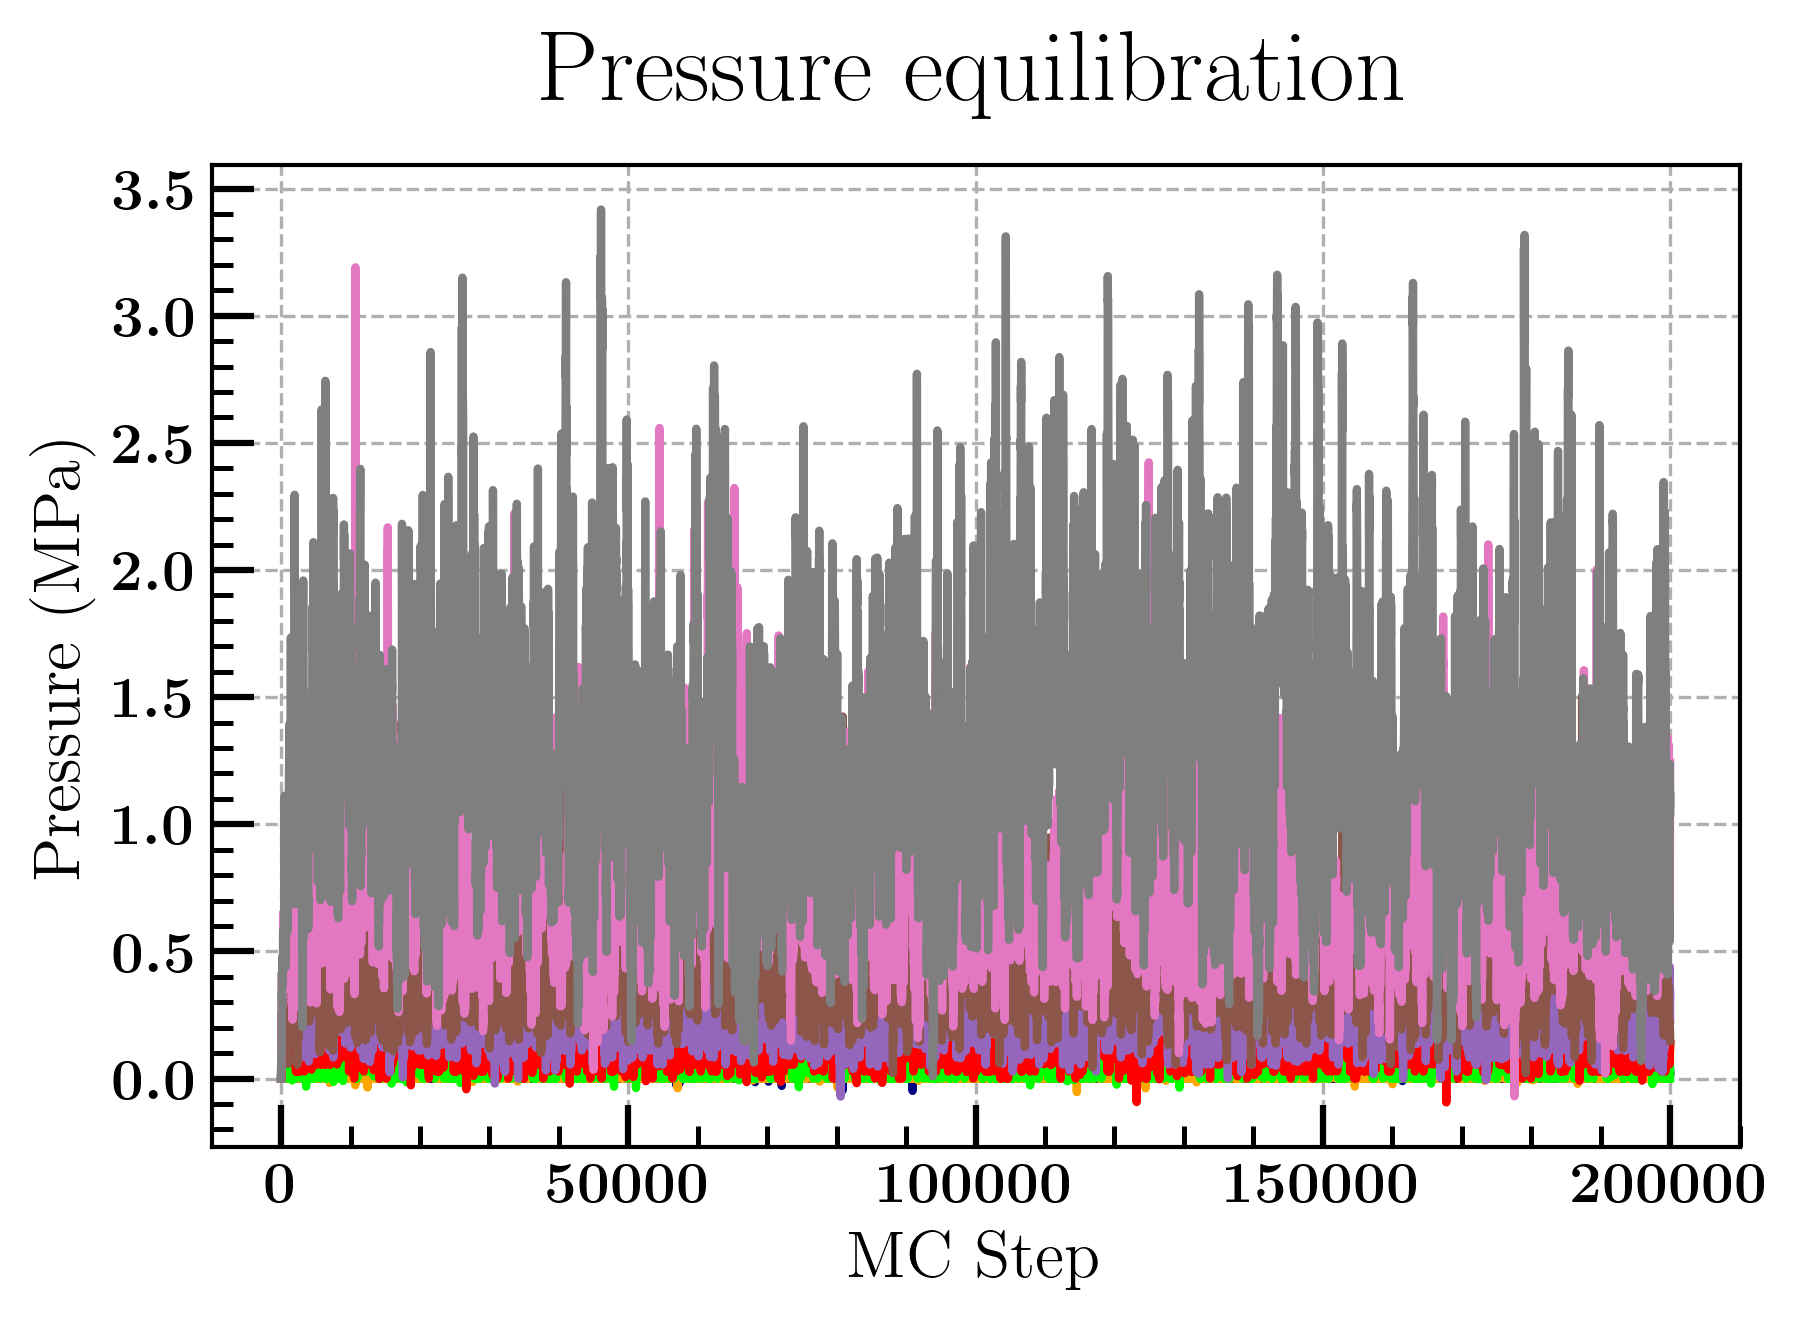

In [5]:
pressures = []
for mu_adsorbate in mus_adsorbate:
    dirname = f'pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
    thermo = ThermoProps(dirname + "/gcmc.out.prp")
    pressures.append(np.mean(thermo.prop("Pressure", start=60000)))
    plt.plot(thermo.prop("MC_STEP"), thermo.prop("Pressure").to("MPa"))
plt.title("Pressure equilibration")
plt.xlabel("MC Step")
plt.ylabel("Pressure (MPa)")
pass

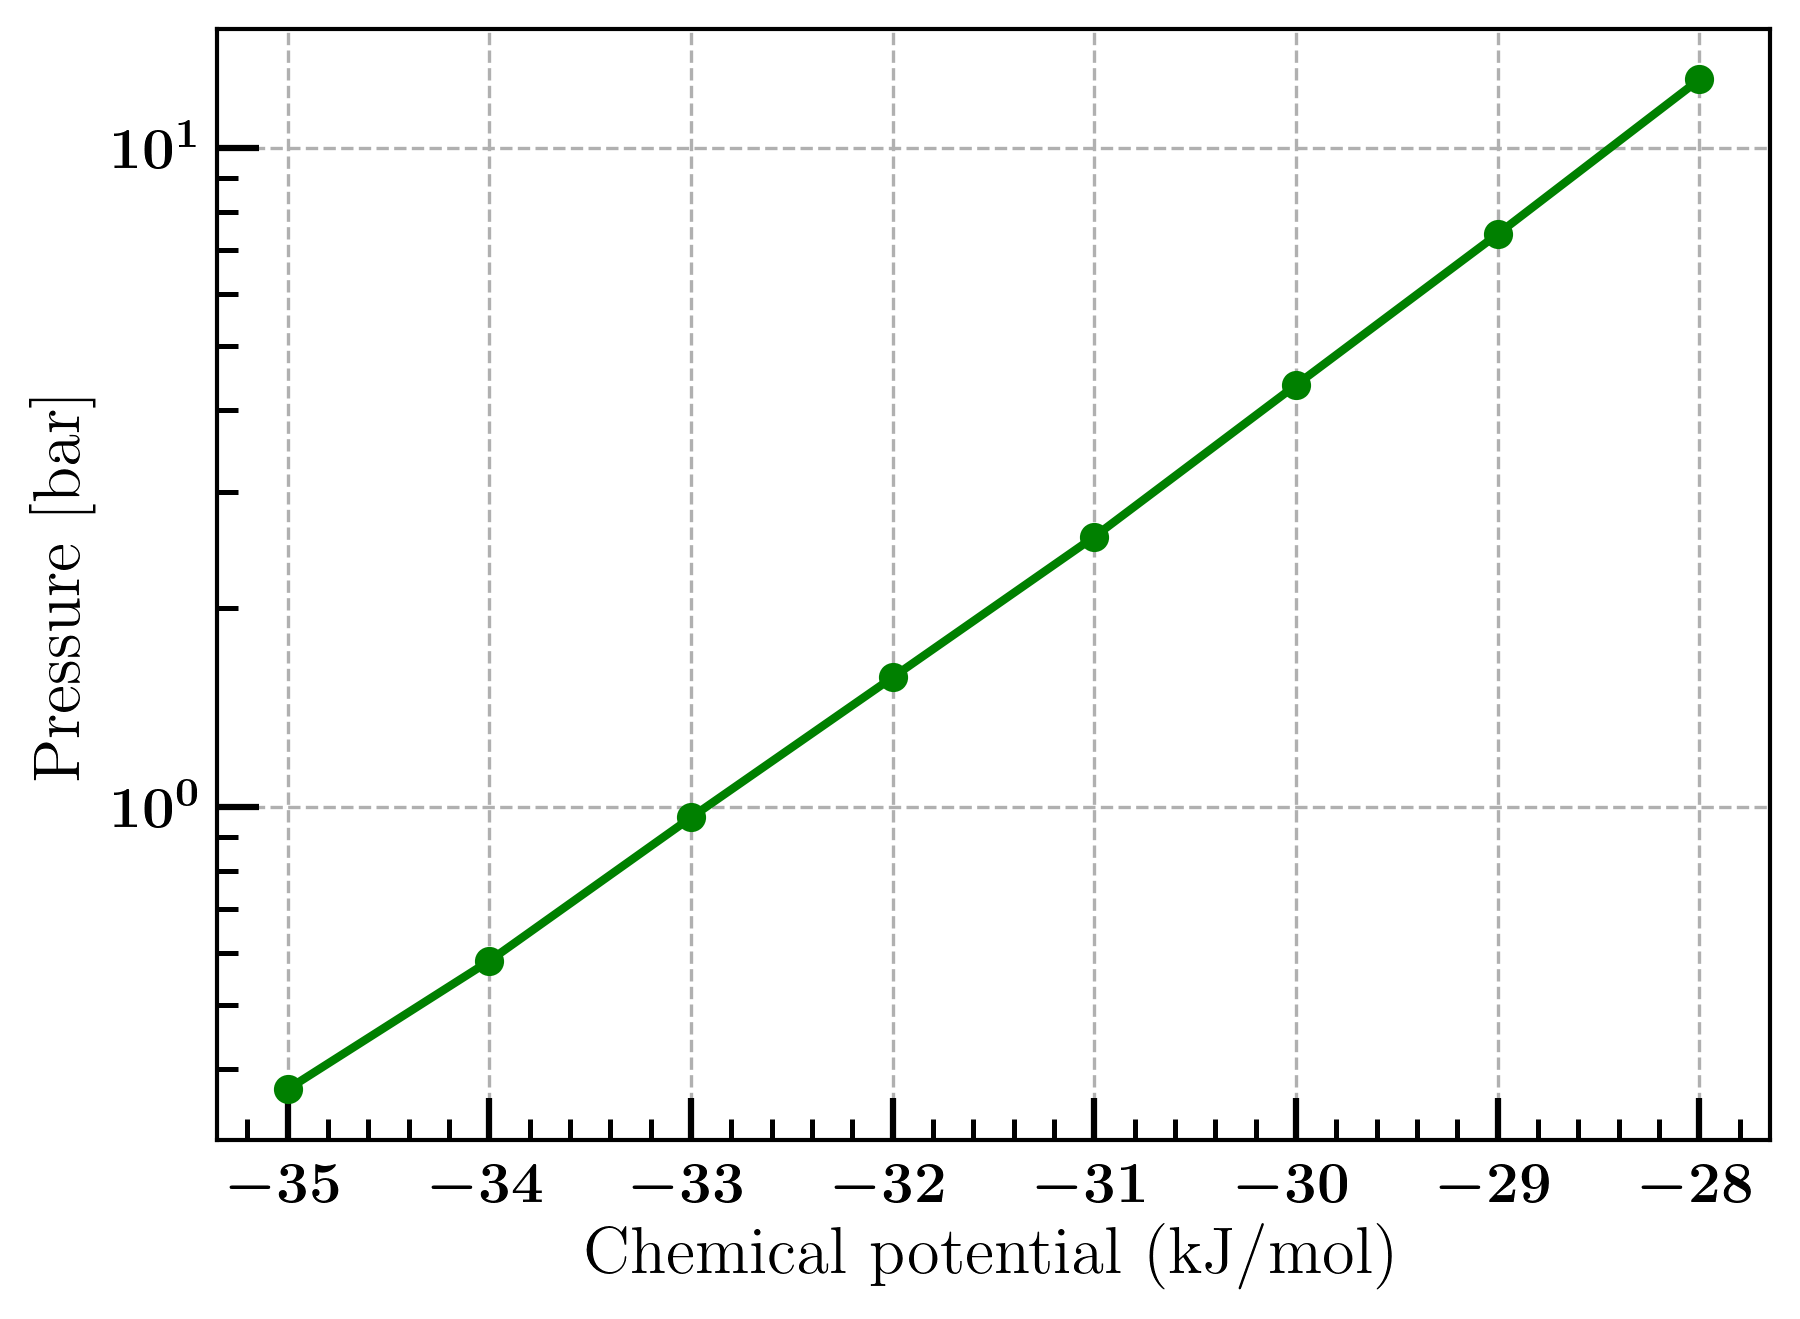

In [6]:
plt.plot(mus_adsorbate, pressures, 'go-')
plt.xlabel("Chemical potential (kJ/mol)")
plt.ylabel("Pressure [bar]")
plt.yscale('log')


In [7]:
slope, intercept, r_value, p_value, stderr = linregress(np.log(pressures).flatten(),y=mus_adsorbate.flatten())

In [8]:
pressures = [
    6000   ,
    22100  ,
    49180  ,
    121800 ,
    316800 ,
    839700 ,
] * u.Pa

mus = (slope * np.log(pressures.in_units(u.bar)) + intercept) * u.kJ/u.mol
for (mu, pressure) in zip(mus, pressures):
    print(f"We will run at mu = {mu:0.2f} to simulate {pressure:0.0f}")

We will run at mu = -38.51 kJ/mol to simulate 6000 Pa
We will run at mu = -35.93 kJ/mol to simulate 22100 Pa
We will run at mu = -34.35 kJ/mol to simulate 49180 Pa
We will run at mu = -32.56 kJ/mol to simulate 121800 Pa
We will run at mu = -30.67 kJ/mol to simulate 316800 Pa
We will run at mu = -28.74 kJ/mol to simulate 839700 Pa


In [9]:
zeolite_lattice = mbuild.lattice.load_cif(rootdir + 'Resources/cif/zeolites/MFI.cif')

compound_dict = {
    "O" : mbuild.Compound(name="O"),
    "Si" : mbuild.Compound(name="Si")
}

nx = 2
ny = 2
nz = 3

n_unitcells = nx*ny*nz

zeolite = zeolite_lattice.populate(x=nx, y=ny, z=nz, compound_dict=compound_dict)
ff_zeo = foyer.Forcefield(rootdir+'Resources/foyer/TraPPE_zeo.xml')
zeolite_typed = ff_zeo.apply(zeolite)
zeolite.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [10]:
box_list = [zeolite]
species_list = [zeolite_typed, adsorbate_typed]

mols_in_boxes = [[1,0]]

system = mc.System(
    box_list,
    species_list,
    mols_in_boxes=mols_in_boxes,
)

moveset = mc.MoveSet('gcmc', species_list)

custom_args = {
    "charge_style" : "ewald",
    "vdw_cutoff" : 14.0 * u.angstrom,
    "prop_freq" : 10,
    "coord_freq" : 500,
}

for (pressure, mu) in zip(pressures, mus):
    
    dirname = f"zeo_press_{pressure.value:0.0f}"
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    with temporary_cd(dirname):
        
        system = mc.System(
            box_list,
            species_list,
            mols_in_boxes=mols_in_boxes,
        )
        
        moveset = mc.MoveSet('gcmc', species_list)
        
        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=200000,
            temperature=temperature,
            chemical_potentials = ["none", mu],
            **custom_args
        )

Treating <Structure 3456 atoms; 1 residues; 0 bonds; PBC (orthogonal); NOT parametrized> as a non-insertable rigid species since it has no bonds
Treating <Structure 3456 atoms; 1 residues; 0 bonds; PBC (orthogonal); NOT parametrized> as a non-insertable rigid species since it has no bonds
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Treating <Structure 3456 atoms; 1 residues; 0 bonds; PBC (orthogonal); NOT parametrized> as a non-insertable rigid species since it has no bonds
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cas

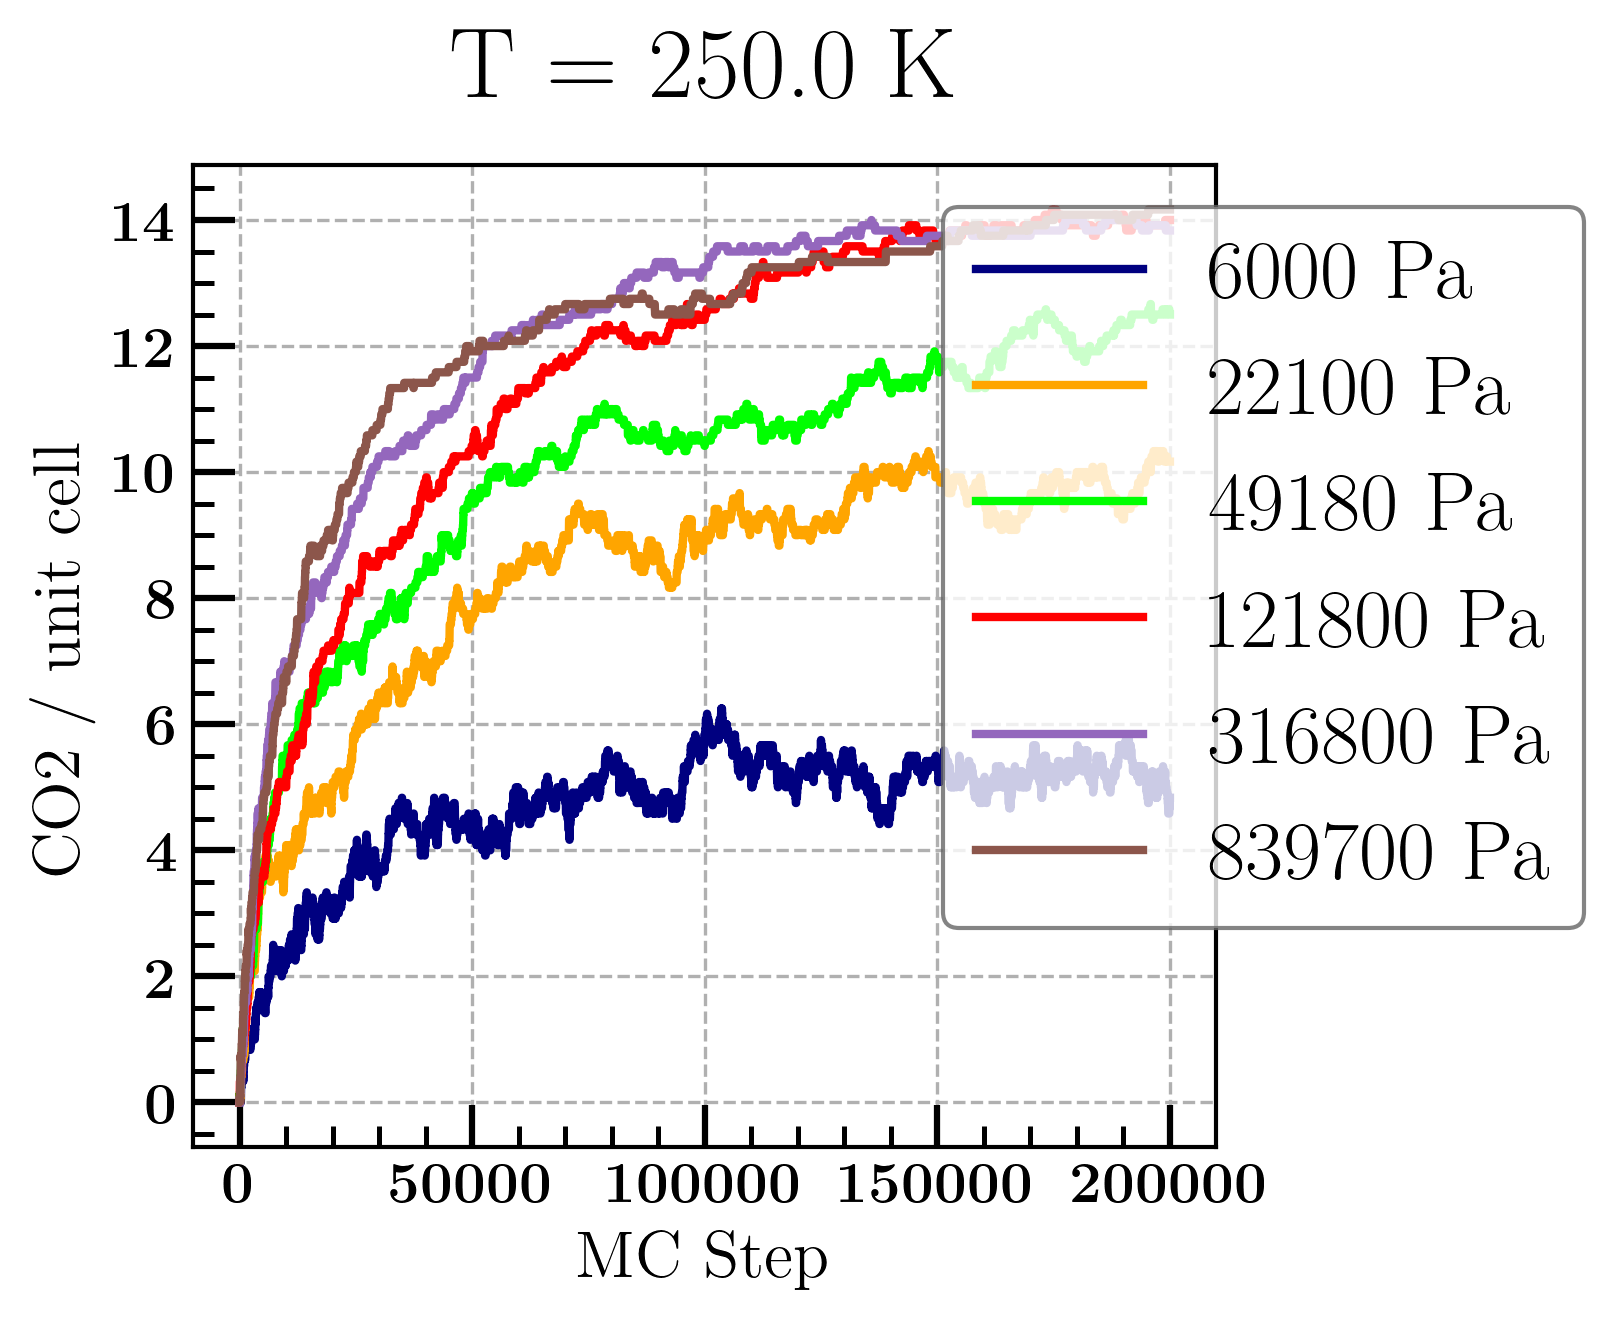

In [11]:
loading = []
for pressure in pressures:
    dirname = f"zeo_press_{pressure.value:0.0f}"
    thermo = ThermoProps(f"{dirname}/gcmc.out.prp")
    
    loading.append(np.mean(thermo.prop("Nmols_2", start=60000)/n_unitcells))
    plt.plot(thermo.prop("MC_STEP"), thermo.prop("Nmols_2")/n_unitcells, label=f"{pressure:0.0f}")
    
plt.title(f"T = {temperature:0.1f}")
plt.xlabel('MC Step')
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', ncol=1)
plt.ylabel('CO2 / unit cell')
plt.show()

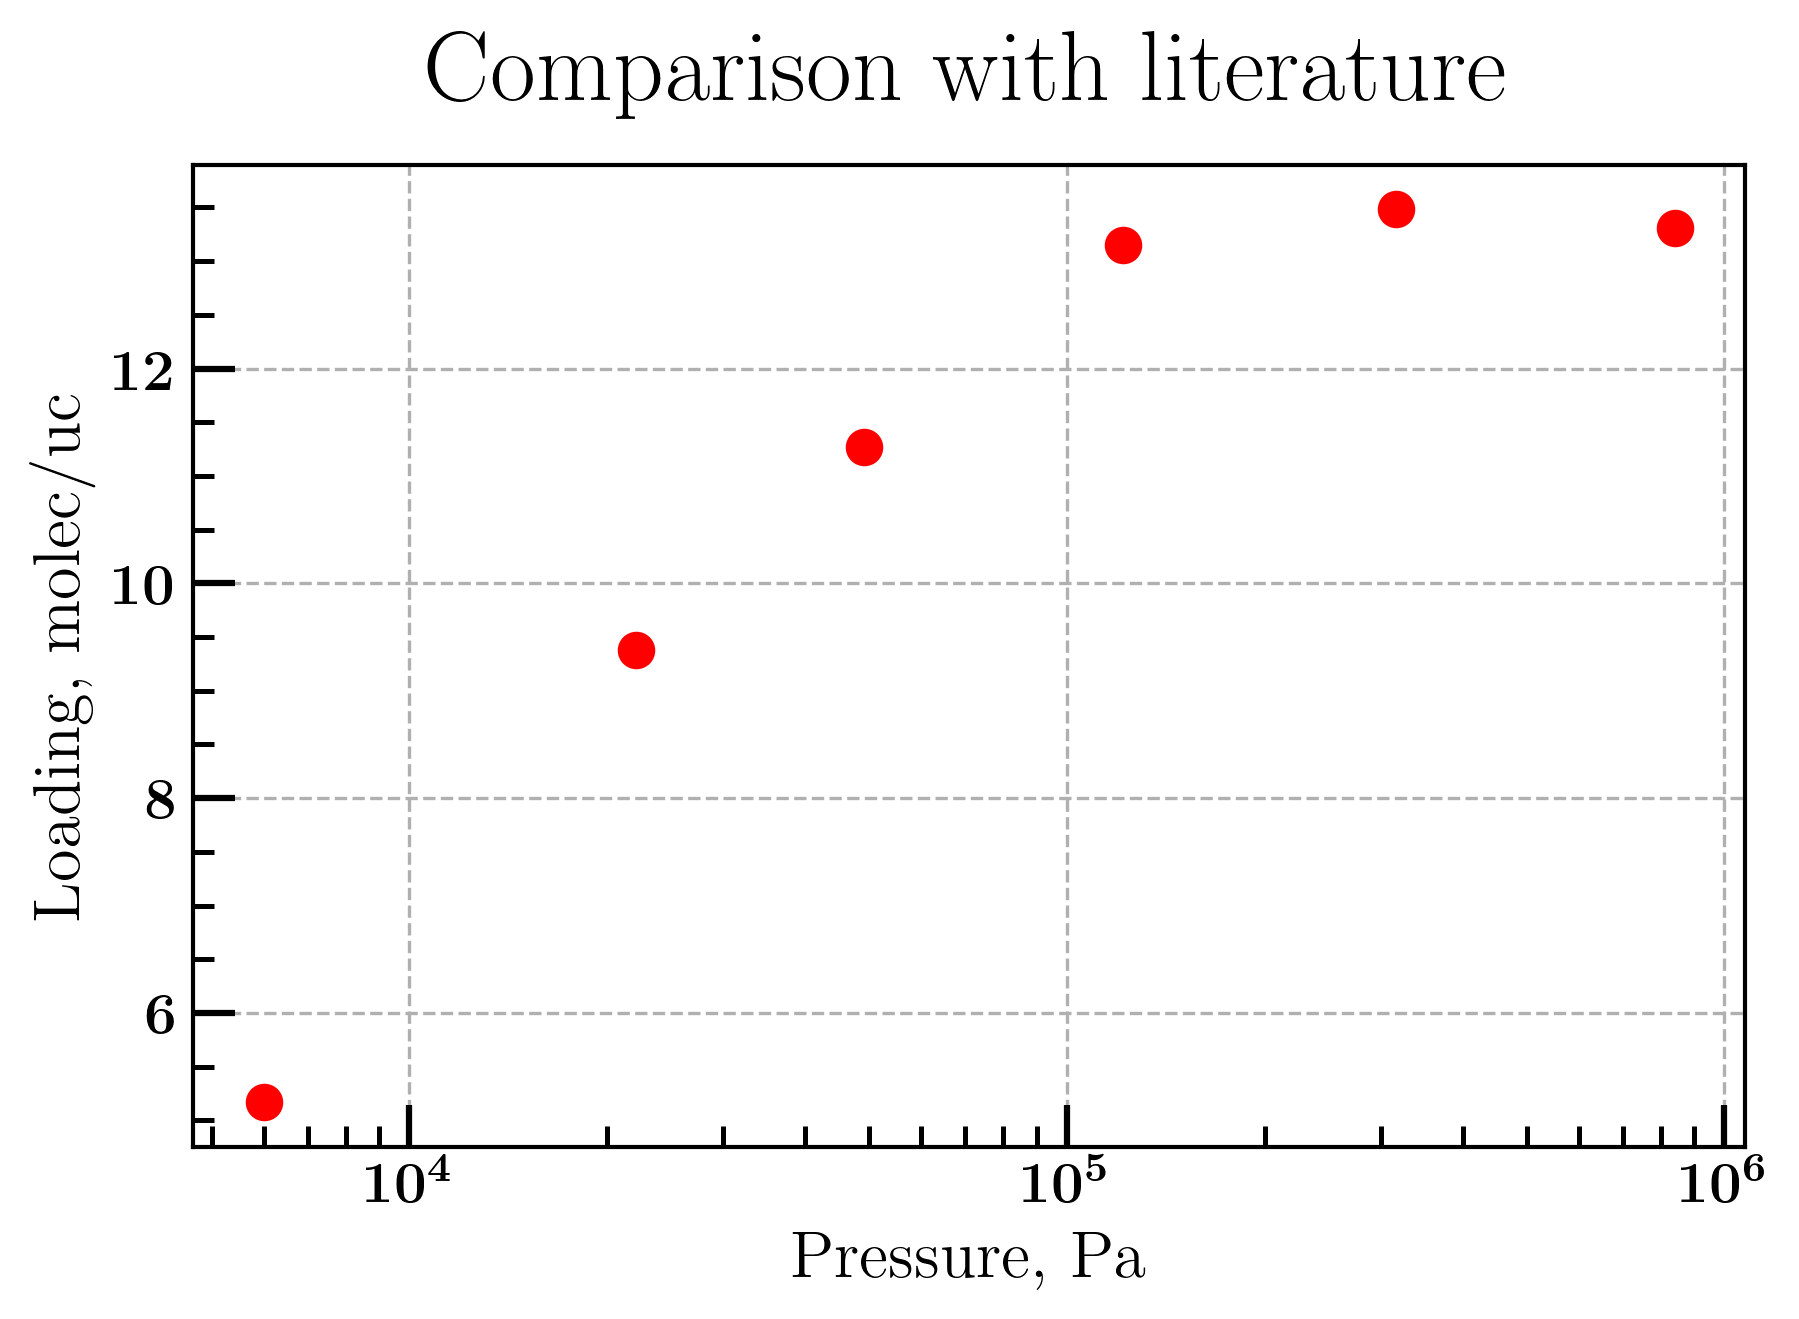

In [12]:
plt.plot(pressures, loading, 'ro', markersize=8)
plt.title("Comparison with literature")
plt.xlabel("Pressure, Pa")
plt.ylabel("Loading, molec/uc")
plt.xscale("log")